<a href="https://colab.research.google.com/github/datarae/Research_Academia/blob/main/Black%20Box%20Vs.%20Interpretable%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Black Box Algorithm vs. Interpretable Model**
## A Demonstration of Reproducible Models on Complex Datasets, for More Responsible Science

--------------------------------------

**Created by Rae Chipera**

**National University**


This project is created with a synthetic dataset and is for instructional or educational purposes only.

###**Methodology**

1. Create synthetic dataset of satellite data, or other scientific application.

   *  This is a synthetic satellite image dataset with anomalies (in red). Satellite data was chosen because one might be tempted to use unsupervised learning or black box models for such an application.
   *  Each pixel has four features: brightness, texture, near-infrared reflection, and thermal signature.
   *  Anomalies follow specific rules based on these features.

2. Create a function to train and evaluate a deep learning black box model. For this, let's use an autoencoder. One would expect a black box model to:

   *  Have high accuracy (~90%)
   *  Use multiple layers
   *  Provide opaque reasoning (in other words, it can't explain why it made specific decisions.)
   *  Shows predictions with color-coded results (true positives, false positives, etc.)

3. Create a function to train a tree-based model. Usually, one expects this model to:

   *  Have a slightly lower accuracy than a deep learning black box model
   *  Make predictions using explicit rules that anyone can understand
   *  Display the complete decision path for any selected point
   *  Allow one to follow exactly how each prediction was made

4. Create a function to train and evaluate a reproducible deep learning-style model. For this, let's use reservoir computing. One would expect an RC model to have:

   *  Fixed random weights. The core of an RC model is a RNN with randomly initialized weights that are never trained.
   *  Linear readout. Only the output layer weights are trained, typically using simple linear methods.
   *  Dynamic memory. The reservoir acts as non-linear dynamic memory that transforms inputs into a high-dimensional space.
   *  Explainable decisions. Since the readout layer is linear, one can trace exactly how much each feature contributes to the final decision.

5. Create a function to compare all three models.  This will include visualizations of:
   *  Side-by-side prediction maps,
   *  ROC curves comparing performance,
   *  Reconstruction error distributions for the autoencoder
   *  Decision tree visualization
   *  Reservoir neuron activation patterns
   *  Feature importance comparisons

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.linear_model import Ridge

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# Function to generate synthetic satellite image data with anomalies
def generate_satellite_data(grid_size=16, noise_level=0.1):
    """
    Generate synthetic satellite data with anomalies.

    Each pixel has 4 features:
    - brightness: Overall light intensity (0-1)
    - texture: Variation in pixel neighborhood (0-1)
    - near_infrared: Reflection in NIR spectrum (0-1)
    - thermal: Heat signature (0-1)

    Anomalies are determined by two rules:
    1. High brightness (>0.65) with low near-infrared (<0.5)
    2. High thermal (>0.7) with low texture (<0.4)
    """
    # Total number of pixels
    n_samples = grid_size * grid_size

    # Generate grid coordinates
    x_coords = np.repeat(np.arange(grid_size), grid_size)
    y_coords = np.tile(np.arange(grid_size), grid_size)

    # Generate features with some natural correlation
    brightness = 0.3 + 0.4 * np.random.random(n_samples)
    near_infrared = brightness * 0.7 + 0.3 * np.random.random(n_samples)
    texture = 0.2 + 0.6 * np.random.random(n_samples)
    thermal = 0.3 + 0.3 * np.random.random(n_samples)

    # Add boost to thermal for high brightness areas (natural correlation)
    thermal[brightness > 0.6] += 0.2

    # Add some noise
    brightness += noise_level * np.random.randn(n_samples)
    near_infrared += noise_level * np.random.randn(n_samples)
    texture += noise_level * np.random.randn(n_samples)
    thermal += noise_level * np.random.randn(n_samples)

    # Clip values to valid range [0, 1]
    brightness = np.clip(brightness, 0, 1)
    near_infrared = np.clip(near_infrared, 0, 1)
    texture = np.clip(texture, 0, 1)
    thermal = np.clip(thermal, 0, 1)

    # Create feature matrix
    X = np.column_stack([brightness, texture, near_infrared, thermal])
    feature_names = ['brightness', 'texture', 'near_infrared', 'thermal']

    # Determine anomalies based on rules
    rule1 = (brightness > 0.65) & (near_infrared < 0.5)  # Artificial structures
    rule2 = (thermal > 0.7) & (texture < 0.4)  # Hidden heat sources
    y = np.logical_or(rule1, rule2).astype(int)

    # Create DataFrame for easier manipulation
    df = pd.DataFrame({
        'x': x_coords,
        'y': y_coords,
        'brightness': brightness,
        'texture': texture,
        'near_infrared': near_infrared,
        'thermal': thermal,
        'anomaly': y,
        'rule1': rule1.astype(int),
        'rule2': rule2.astype(int)
    })

    return df, X, y, feature_names


In [14]:
# Function to visualize satellite data
def plot_satellite_data(df, title, predictions=None, ax=None):
    """
    Visualize the satellite data as a grid with anomalies highlighted.

    Parameters:
    - df: DataFrame containing x, y coordinates and anomaly labels
    - title: Plot title
    - predictions: Optional array of predicted anomalies
    - ax: Optional matplotlib axis to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Get the grid size from the data
    grid_size = int(np.sqrt(len(df)))

    # Create grid for visualization
    grid = np.zeros((grid_size, grid_size, 3))  # RGB grid

    if predictions is None:
        # Just show ground truth
        for idx, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])
            # Ensure we don't exceed grid boundaries
            if 0 <= x < grid_size and 0 <= y < grid_size:
                if row['anomaly'] == 1:
                    grid[y, x] = [1, 0, 0]  # Red for anomalies
                else:
                    grid[y, x] = [0.8, 0.8, 0.8]  # Light gray for normal
    else:
        # Show predictions vs ground truth
        for idx, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])
            # Ensure we don't exceed grid boundaries
            if 0 <= x < grid_size and 0 <= y < grid_size:
                true_label = row['anomaly']
                pred_label = predictions[idx]

                if true_label == 1 and pred_label == 1:
                    grid[y, x] = [0, 0.8, 0]  # Green for true positives
                elif true_label == 0 and pred_label == 1:
                    grid[y, x] = [1, 0.8, 0]  # Yellow for false positives
                elif true_label == 1 and pred_label == 0:
                    grid[y, x] = [0.8, 0, 0.8]  # Purple for false negatives
                else:
                    grid[y, x] = [0, 0.6, 0.8]  # Blue for true negatives

    ax.imshow(grid, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax


In [15]:
# Function to build and train autoencoder for anomaly detection (black box model)
def build_autoencoder_model(X_train, X_test, y_test, scaler=None):
    """
    Build and train an autoencoder for anomaly detection.

    Returns the model, predictions, and reconstruction errors.
    """
    # Scale the data
    if scaler is None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    # Define the input dimension
    input_dim = X_train.shape[1]

    # Define the encoder
    encoding_dim = 2  # Compressed representation size

    # Build the autoencoder model
    input_layer = Input(shape=(input_dim,))

    # Encoder layers
    encoded = Dense(8, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder layers
    decoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)

    # Separate encoder model for visualization
    encoder = Model(inputs=input_layer, outputs=encoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=100,
        batch_size=32,
        shuffle=True,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Get reconstruction error on test set
    X_test_pred = autoencoder.predict(X_test_scaled)
    mse = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

    # Find threshold for anomaly detection
    # Here we're using percentile-based approach, but could use other methods
    threshold = np.percentile(mse, 95)  # Assume top 5% are anomalies

    # Make predictions based on reconstruction error
    y_pred = (mse > threshold).astype(int)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)

    return autoencoder, encoder, y_pred, mse, threshold, accuracy, scaler, history

In [16]:
# Function to train and evaluate transparent model (Decision Tree)
def train_transparent_model(X_train, y_train, X_test, y_test, feature_names):
    """
    Train a transparent decision tree model.

    Returns the model, predictions on test data, and tree visualization.
    """
    # Create a decision tree classifier
    model = DecisionTreeClassifier(
        max_depth=4,  # Limit depth for interpretability
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = model.score(X_test, y_test)

    return model, y_pred, accuracy

In [17]:
# Function to explain a transparent model prediction for a specific sample
def explain_transparent_prediction(model, X_sample, feature_names):
    """
    Trace the decision path for a sample through the decision tree.

    Returns a list of decision steps.
    """
    # Get the decision path
    decision_path = model.decision_path(X_sample.reshape(1, -1))

    # Get the node feature indices, thresholds, and children
    n_nodes = model.tree_.node_count
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    # Get leaf value (prediction)
    leaf_id = model.apply(X_sample.reshape(1, -1))[0]
    leaf_value = model.tree_.value[leaf_id][0]
    prediction = np.argmax(leaf_value)

    # Trace the path
    node_index = 0
    path = []

    while feature[node_index] != -2:  # -2 indicates a leaf node
        if X_sample[feature[node_index]] <= threshold[node_index]:
            path.append(f"{feature_names[feature[node_index]]} <= {threshold[node_index]:.2f} ✓")
            node_index = model.tree_.children_left[node_index]
        else:
            path.append(f"{feature_names[feature[node_index]]} > {threshold[node_index]:.2f} ✓")
            node_index = model.tree_.children_right[node_index]

    path.append(f"Prediction: {'ANOMALY' if prediction == 1 else 'NORMAL'}")

    return path


In [19]:
# Reservoir Computing implementation
class ReservoirComputing:
    def __init__(self, n_inputs, n_reservoir=200, spectral_radius=0.95, sparsity=0.1,
                 noise=0.001, random_state=None):
        """
        Initialize a Reservoir Computing model.

        Parameters:
        - n_inputs: Number of input features
        - n_reservoir: Size of the reservoir
        - spectral_radius: Spectral radius of the reservoir weights
        - sparsity: Sparsity of the reservoir weights
        - noise: Amount of noise added to the reservoir state
        - random_state: Random seed for reproducibility
        """
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise

        if random_state is not None:
            np.random.seed(random_state)

        # Initialize input weights (W_in)
        self.W_in = np.random.randn(n_reservoir, n_inputs) * 0.1

        # Initialize reservoir weights (W)
        # Create sparse random matrix
        W = np.random.rand(n_reservoir, n_reservoir) - 0.5
        # Make it sparse
        W[np.random.rand(*W.shape) > sparsity] = 0
        # Compute the spectral radius
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # Rescale to desired spectral radius
        self.W = W * (spectral_radius / radius) if radius > 0 else W

        # Initialize readout with Ridge regression
        self.readout = Ridge(alpha=1e-6)

        # For visualization and interpretation
        self.feature_weights = None
        self.reservoir_weights = None

    def _update_reservoir(self, x, r):
        """
        Update the reservoir state.

        Parameters:
        - x: Input data point
        - r: Current reservoir state

        Returns:
        - Updated reservoir state
        """
        # Compute new reservoir state
        r_new = np.tanh(np.dot(self.W_in, x) + np.dot(self.W, r))
        # Add noise
        r_new += self.noise * np.random.randn(self.n_reservoir)
        return r_new

    def _compute_reservoir_states(self, X):
        """
        Compute reservoir states for all input data.

        Parameters:
        - X: Input data of shape (n_samples, n_features)

        Returns:
        - Reservoir states for all samples
        """
        n_samples = X.shape[0]

        # Initialize reservoir states
        r = np.zeros((n_samples, self.n_reservoir))

        # Compute reservoir states for each sample
        r_t = np.zeros(self.n_reservoir)
        for t in range(n_samples):
            r_t = self._update_reservoir(X[t], r_t)
            r[t] = r_t

        return r

    def fit(self, X, y):
        """
        Train the reservoir computing model.

        Parameters:
        - X: Input data of shape (n_samples, n_features)
        - y: Target labels

        Returns:
        - self
        """
        # Compute reservoir states
        r = self._compute_reservoir_states(X)

        # Train readout using ridge regression
        self.readout.fit(r, y)

        # Save weights for interpretation
        self.reservoir_weights = self.readout.coef_

        # Calculate direct connection weights from features to output
        # This helps in interpretation
        self.feature_weights = np.zeros(self.n_inputs)
        for i in range(self.n_inputs):
            # Calculate the weighted sum of reservoir responses to each input feature
            feature_influence = np.dot(self.W_in[:, i], self.reservoir_weights)
            self.feature_weights[i] = np.abs(feature_influence).mean()

        # Normalize feature weights for easier interpretation
        if np.sum(self.feature_weights) > 0:
            self.feature_weights = self.feature_weights / np.sum(self.feature_weights)

        return self

    def predict(self, X):
        """
        Make predictions using the trained reservoir model.

        Parameters:
        - X: Input data of shape (n_samples, n_features)

        Returns:
        - Predicted labels
        """
        # Compute reservoir states
        r = self._compute_reservoir_states(X)

        # Make predictions using the readout
        y_pred = self.readout.predict(r)

        # Convert to binary predictions for classification
        return (y_pred > 0.5).astype(int)

    def predict_proba(self, X):
        """
        Predict probability estimates.

        Parameters:
        - X: Input data

        Returns:
        - Probability estimates
        """
        # Compute reservoir states
        r = self._compute_reservoir_states(X)

        # Get raw predictions
        y_pred = self.readout.predict(r)

        # Clip to [0, 1] range and reshape for scikit-learn compatibility
        y_pred = np.clip(y_pred, 0, 1)

        # Return probabilities for both classes
        return np.column_stack([1 - y_pred, y_pred])

    def get_feature_importance(self, feature_names=None):
        """
        Get feature importance based on the reservoir's response to inputs.

        Parameters:
        - feature_names: Names of the input features

        Returns:
        - Dictionary mapping feature names to importance scores
        """
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(self.n_inputs)]

        return dict(zip(feature_names, self.feature_weights))

    def explain_prediction(self, x, feature_names=None):
        """
        Explain a prediction by showing the contribution of each feature.

        Parameters:
        - x: Input data point
        - feature_names: Names of the input features

        Returns:
        - Dictionary with explanation details
        """
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(self.n_inputs)]

        # Get reservoir state for this input
        r_t = np.zeros(self.n_reservoir)
        r_t = self._update_reservoir(x, r_t)

        # Get individual reservoir neuron activations
        neuron_activations = r_t

        # Get prediction
        pred = self.readout.predict(r_t.reshape(1, -1))[0]

        # Calculate feature contributions
        feature_contributions = {}
        for i, name in enumerate(feature_names):
            # For each feature, calculate its contribution through the reservoir
            direct_effect = self.W_in[:, i] * x[i]
            weighted_effect = np.dot(direct_effect, self.reservoir_weights)
            feature_contributions[name] = weighted_effect

        # Normalize contributions
        total = sum(abs(v) for v in feature_contributions.values())
        if total > 0:
            normalized_contributions = {k: v/total for k, v in feature_contributions.items()}
        else:
            normalized_contributions = feature_contributions

        return {
            'prediction': pred,
            'binary_prediction': 1 if pred > 0.5 else 0,
            'reservoir_state': neuron_activations,
            'feature_contributions': normalized_contributions
        }

In [20]:
# Train reservoir computing model for anomaly detection
def train_reservoir_model(X_train, y_train, X_test, y_test, feature_names, scaler=None):
    """
    Train a transparent reservoir computing model.

    Returns the model, predictions, and feature importances.
    """
    # Scale the data
    if scaler is None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = scaler.transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    # Create and train the reservoir model
    model = ReservoirComputing(
        n_inputs=X_train.shape[1],
        n_reservoir=100,  # Number of reservoir neurons
        spectral_radius=0.9,
        sparsity=0.1,
        noise=0.001,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)

    # Get feature importance
    feature_importance = model.get_feature_importance(feature_names)

    return model, y_pred, accuracy, scaler, feature_importance


Generating synthetic satellite data...

Training black box autoencoder model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Training transparent decision tree model...

Training transparent reservoir computing model...

Saved model predictions to 'model_predictions_comparison.png'
Saved model evaluation metrics to 'model_evaluation_metrics.png'
Saved model interpretability visualizations to 'model_interpretability.png'


MODEL COMPARISON: BLACK BOX VS TRANSPARENT APPROACHES

Accuracy Comparison:
  - Black Box Autoencoder:      0.8701
  - Decision Tree:              0.9610
  - Reservoir Computing:        0.8052

AUC-ROC Comparison:
  - Black Box Autoencoder:      0.8207
  - Decision Tree:              0.8678
  - Reservoir Computing:        0.6957

Explainability Comparison for Sample 1:
  Feature Values:
    - brightness: 0.73
    - texture: 0.31
    - near_infrared: 0.60
    - thermal: 0.76
  True Label: ANOMALY
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

  1. BLACK BOX MODEL (Autoencoder) Expla

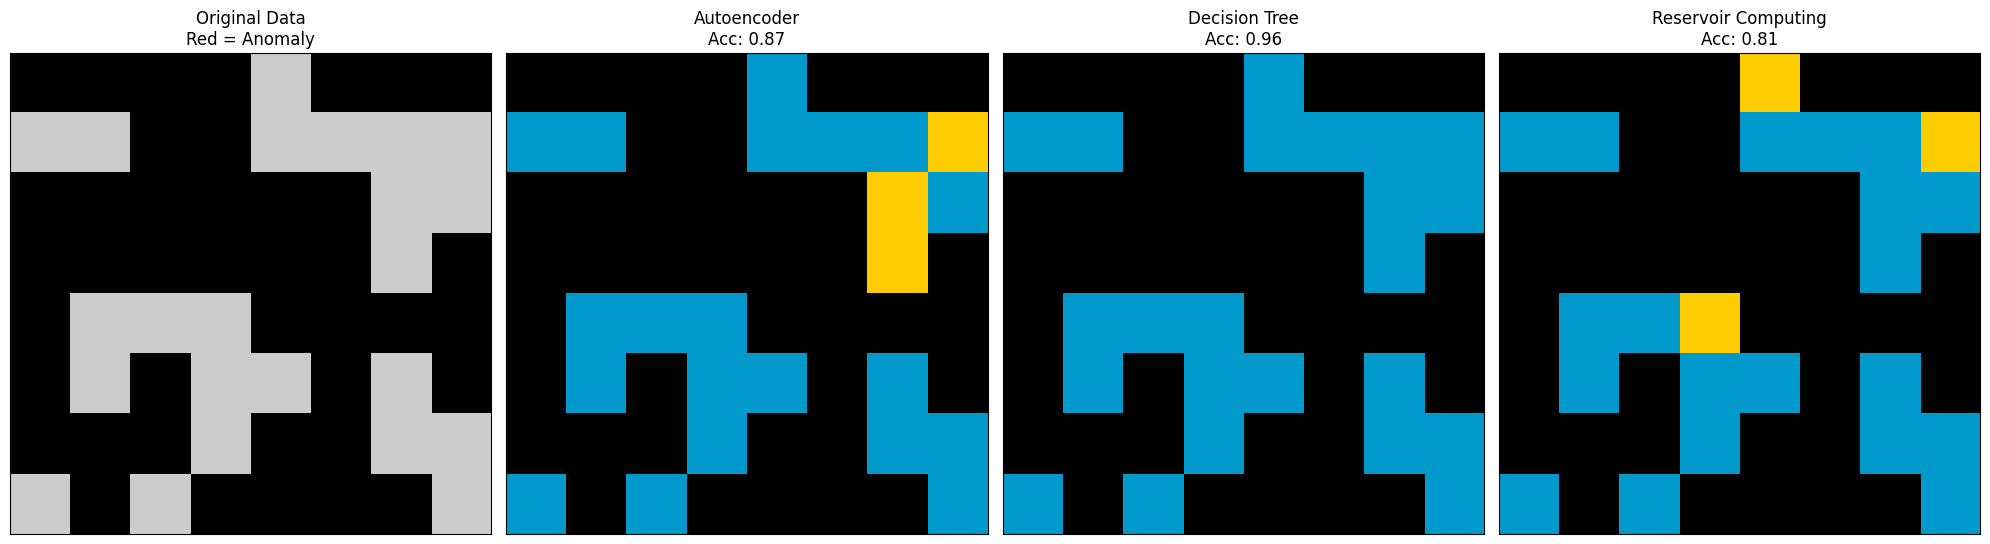

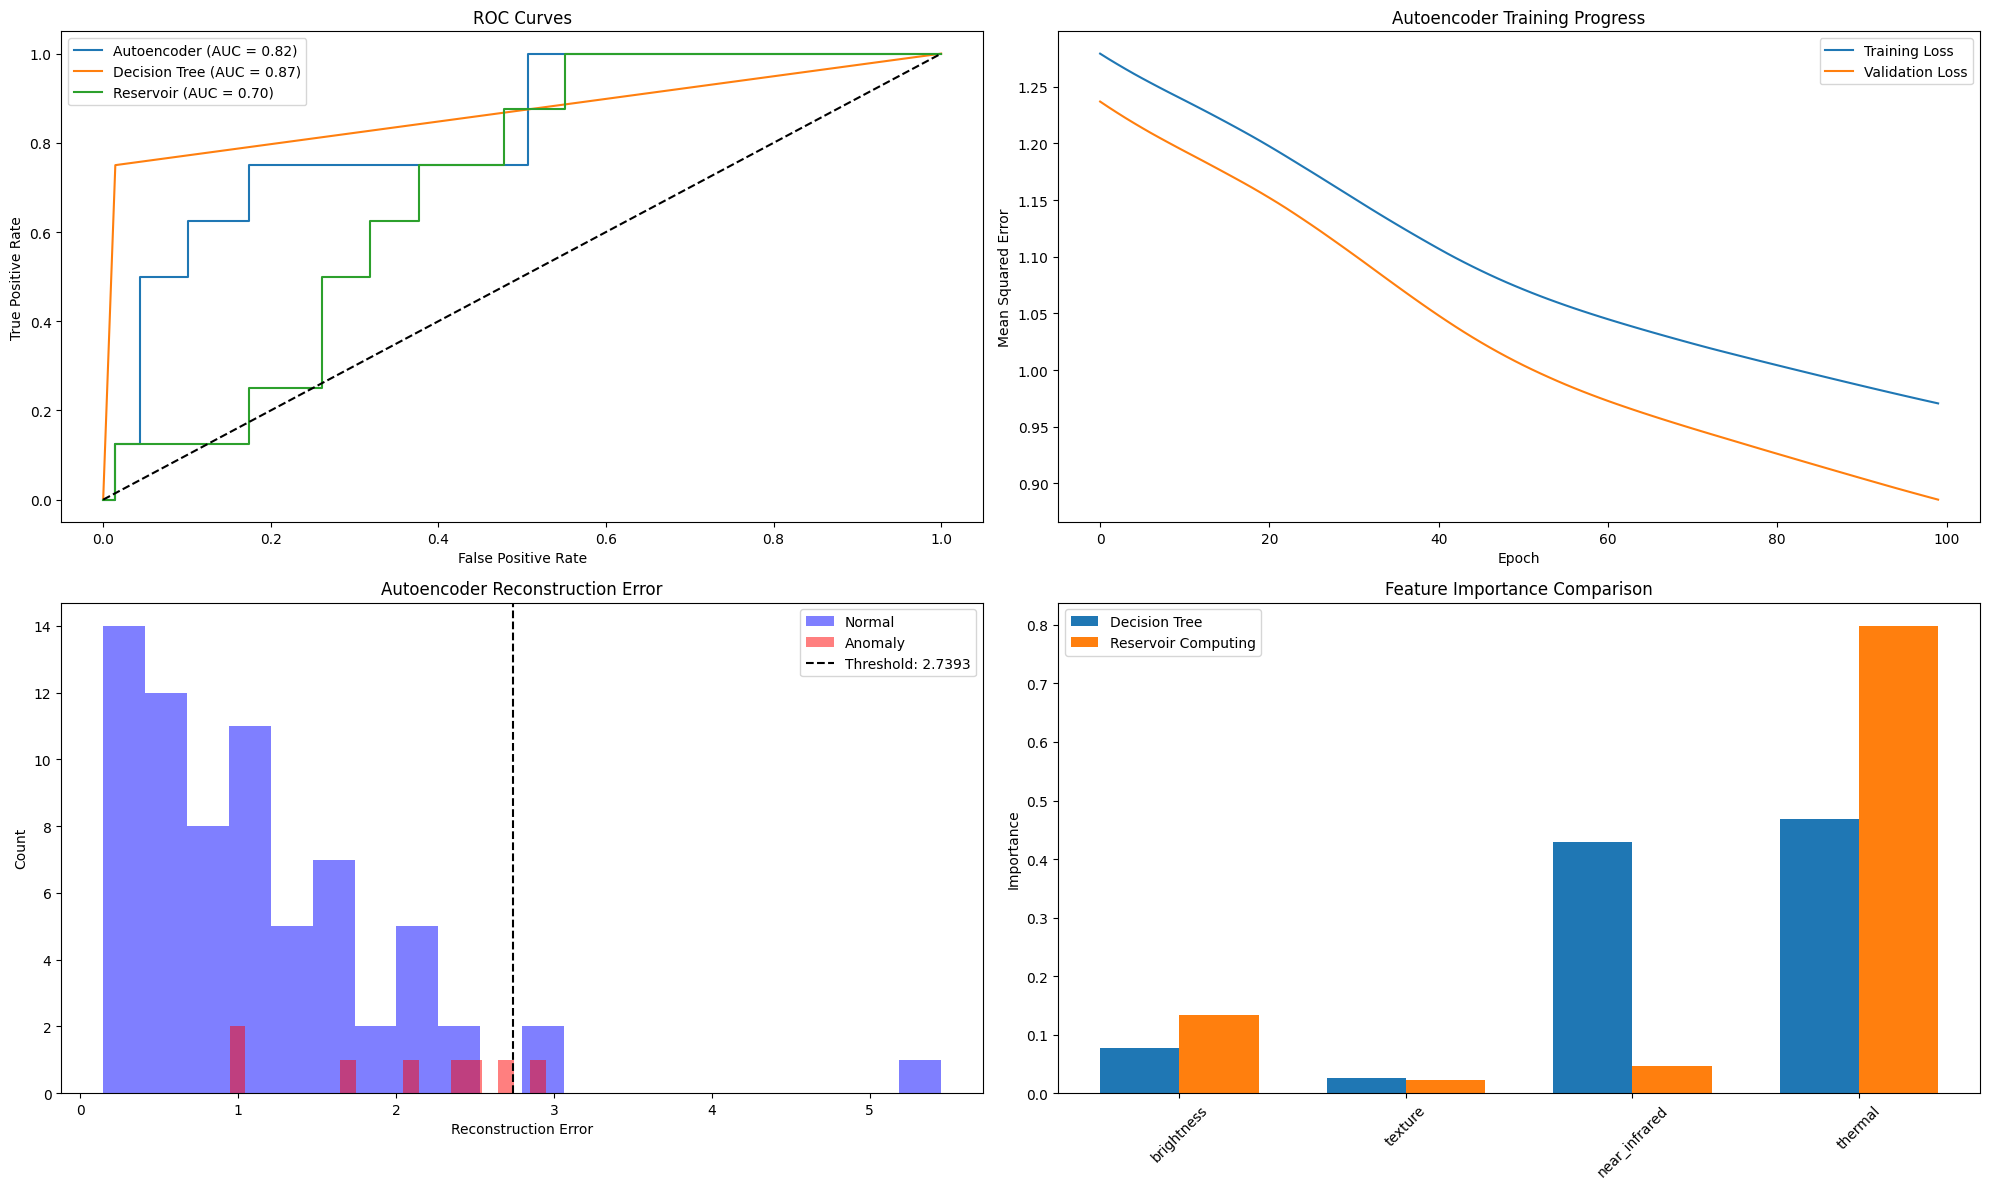

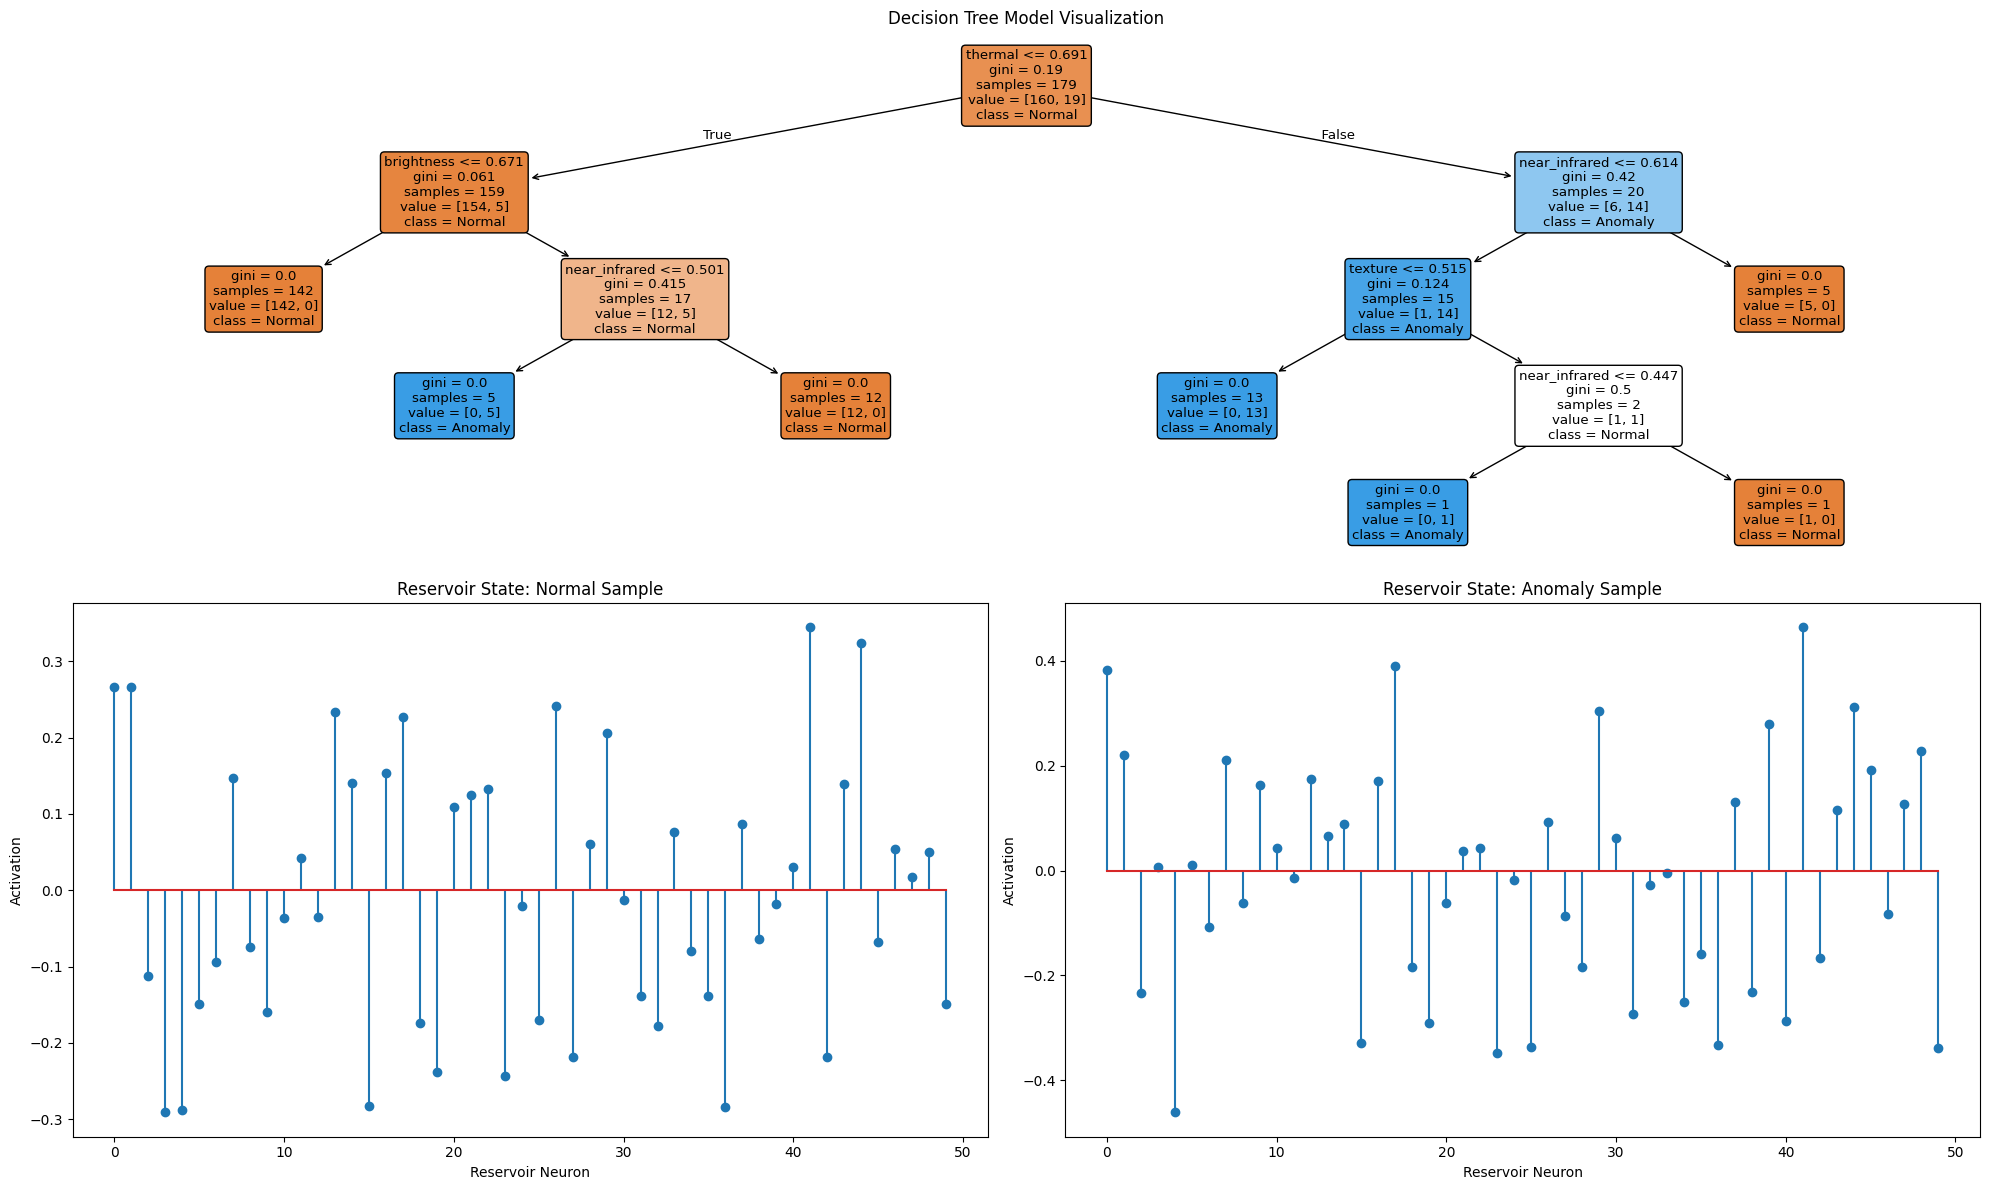

In [27]:
# Main function to demonstrate all three models
def main_combined():
    # Generate synthetic satellite data
    print("Generating synthetic satellite data...")
    df, X, y, feature_names = generate_satellite_data(grid_size=16)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, np.arange(len(X)), test_size=0.3, random_state=42, stratify=y
    )

    # Create test dataframe for visualization
    df_test = df.iloc[indices_test].copy().reset_index(drop=True)

    # To properly train the autoencoder, we should only use non-anomalous data
    X_train_normal = X_train[y_train == 0]

    # Train black box model (autoencoder)
    print("\nTraining black box autoencoder model...")
    autoencoder, encoder, ae_pred, mse, threshold, ae_accuracy, ae_scaler, history = build_autoencoder_model(
        X_train_normal, X_test, y_test
    )

    # Train decision tree model
    print("\nTraining transparent decision tree model...")
    dt_model, dt_pred, dt_accuracy = train_transparent_model(
        X_train, y_train, X_test, y_test, feature_names
    )

    # Train reservoir computing model
    print("\nTraining transparent reservoir computing model...")
    rc_model, rc_pred, rc_accuracy, rc_scaler, feature_importance = train_reservoir_model(
        X_train, y_train, X_test, y_test, feature_names
    )

    # Calculate ROC curves for model comparison
    # For autoencoder
    fpr_ae, tpr_ae, _ = roc_curve(y_test, mse)
    roc_auc_ae = auc(fpr_ae, tpr_ae)

    # For decision tree
    dt_proba = dt_model.predict_proba(X_test)[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)
    roc_auc_dt = auc(fpr_dt, tpr_dt)

    # For reservoir computing
    rc_proba = rc_model.predict_proba(rc_scaler.transform(X_test))[:, 1]
    fpr_rc, tpr_rc, _ = roc_curve(y_test, rc_proba)
    roc_auc_rc = auc(fpr_rc, tpr_rc)

    # Create figures to display the results
    # Figure 1: Original data and model predictions
    plt.figure(figsize=(20, 6))

    # Plot original data
    ax1 = plt.subplot(1, 4, 1)
    plot_satellite_data(df_test, "Original Data\nRed = Anomaly", ax=ax1)

    # Plot autoencoder predictions
    ax2 = plt.subplot(1, 4, 2)
    plot_satellite_data(df_test, f"Autoencoder\nAcc: {ae_accuracy:.2f}",
                      predictions=ae_pred, ax=ax2)

    # Plot decision tree predictions
    ax3 = plt.subplot(1, 4, 3)
    plot_satellite_data(df_test, f"Decision Tree\nAcc: {dt_accuracy:.2f}",
                      predictions=dt_pred, ax=ax3)

    # Plot reservoir computing predictions
    ax4 = plt.subplot(1, 4, 4)
    plot_satellite_data(df_test, f"Reservoir Computing\nAcc: {rc_accuracy:.2f}",
                      predictions=rc_pred, ax=ax4)

    plt.tight_layout()
    plt.savefig("model_predictions_comparison.png", dpi=300)
    print("\nSaved model predictions to 'model_predictions_comparison.png'")

    # Figure 2: Model evaluation metrics
    plt.figure(figsize=(20, 12))

    # Plot ROC curves
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {roc_auc_ae:.2f})')
    ax1.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
    ax1.plot(fpr_rc, tpr_rc, label=f'Reservoir (AUC = {roc_auc_rc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()

    # Plot autoencoder learning curve
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title('Autoencoder Training Progress')
    ax2.legend()

    # Plot reconstruction error distribution
    ax3 = plt.subplot(2, 2, 3)
    ax3.hist(mse[y_test == 0], bins=20, alpha=0.5, label='Normal', color='blue')
    ax3.hist(mse[y_test == 1], bins=20, alpha=0.5, label='Anomaly', color='red')
    ax3.axvline(threshold, color='k', linestyle='--', label=f'Threshold: {threshold:.4f}')
    ax3.set_xlabel('Reconstruction Error')
    ax3.set_ylabel('Count')
    ax3.set_title('Autoencoder Reconstruction Error')
    ax3.legend()

    # Create a subplot for confusion matrices (would be 3 small ones)
    ax4 = plt.subplot(2, 2, 4)

    # Since we can't easily show 3 confusion matrices in one subplot,
    # let's show feature importance for the transparent models
    importances_dt = dt_model.feature_importances_
    importances_rc = np.array([importance for _, importance in sorted(feature_importance.items())])

    x = np.arange(len(feature_names))
    width = 0.35

    rects1 = ax4.bar(x - width/2, importances_dt, width, label='Decision Tree')
    rects2 = ax4.bar(x + width/2, importances_rc, width, label='Reservoir Computing')

    ax4.set_ylabel('Importance')
    ax4.set_title('Feature Importance Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(feature_names, rotation=45)
    ax4.legend()

    plt.tight_layout()
    plt.savefig("model_evaluation_metrics.png", dpi=300)
    print("Saved model evaluation metrics to 'model_evaluation_metrics.png'")

    # Figure 3: Model interpretability
    plt.figure(figsize=(20, 12))

    # Plot decision tree
    ax1 = plt.subplot(2, 1, 1)
    plot_tree(dt_model, filled=True, feature_names=feature_names,
             class_names=["Normal", "Anomaly"], rounded=True, ax=ax1)
    ax1.set_title("Decision Tree Model Visualization")

    # Plot reservoir states for normal and anomaly samples
    ax2 = plt.subplot(2, 2, 3)

    # Select samples of each class
    normal_idx = np.where(y_test == 0)[0][0]
    anomaly_idx = np.where(y_test == 1)[0][0]

    # Get reservoir states
    normal_sample = X_test[normal_idx]
    anomaly_sample = X_test[anomaly_idx]

    normal_explanation = rc_model.explain_prediction(rc_scaler.transform(normal_sample.reshape(1, -1))[0], feature_names)
    anomaly_explanation = rc_model.explain_prediction(rc_scaler.transform(anomaly_sample.reshape(1, -1))[0], feature_names)

    ax2.stem(normal_explanation['reservoir_state'][:50])  # Show first 50 neurons
    ax2.set_title("Reservoir State: Normal Sample")
    ax2.set_xlabel("Reservoir Neuron")
    ax2.set_ylabel("Activation")

    ax3 = plt.subplot(2, 2, 4)
    ax3.stem(anomaly_explanation['reservoir_state'][:50])  # Show first 50 neurons
    ax3.set_title("Reservoir State: Anomaly Sample")
    ax3.set_xlabel("Reservoir Neuron")
    ax3.set_ylabel("Activation")

    plt.tight_layout()
    plt.savefig("model_interpretability.png", dpi=300)
    print("Saved model interpretability visualizations to 'model_interpretability.png'")

    # Print comparison report
    print("\n\n=========================================")
    print("MODEL COMPARISON: BLACK BOX VS TRANSPARENT APPROACHES")
    print("=========================================")

    print("\nAccuracy Comparison:")
    print(f"  - Black Box Autoencoder:      {ae_accuracy:.4f}")
    print(f"  - Decision Tree:              {dt_accuracy:.4f}")
    print(f"  - Reservoir Computing:        {rc_accuracy:.4f}")

    print("\nAUC-ROC Comparison:")
    print(f"  - Black Box Autoencoder:      {roc_auc_ae:.4f}")
    print(f"  - Decision Tree:              {roc_auc_dt:.4f}")
    print(f"  - Reservoir Computing:        {roc_auc_rc:.4f}")

    # Select a specific anomaly sample to explain across all models
    anomaly_samples = np.where(y_test == 1)[0]
    if len(anomaly_samples) > 0:
        sample_idx = anomaly_samples[0]
    else:
        sample_idx = 0  # Fallback

    sample_features = X_test[sample_idx]
    sample_label = y_test[sample_idx]

    print(f"\nExplainability Comparison for Sample {sample_idx}:")
    print(f"  Feature Values:")
    for i, name in enumerate(feature_names):
        print(f"    - {name}: {sample_features[i]:.2f}")
    print(f"  True Label: {'ANOMALY' if sample_label == 1 else 'NORMAL'}")

    # Black box explanation
    sample_scaled = ae_scaler.transform(sample_features.reshape(1, -1))
    sample_recon = autoencoder.predict(sample_scaled)
    sample_err = np.mean(np.square(sample_scaled - sample_recon))

    print("\n  1. BLACK BOX MODEL (Autoencoder) Explanation:")
    print(f"    - Reconstruction error: {sample_err:.4f}")
    print(f"    - Threshold: {threshold:.4f}")
    print(f"    - Decision: {'ANOMALY' if sample_err > threshold else 'NORMAL'}")
    print("    - No clear explanation of WHY this was classified as it was")

    # Decision Tree explanation
    decision_path = explain_transparent_prediction(dt_model, sample_features, feature_names)

    print("\n  2. DECISION TREE Explanation:")
    print("    - Decision Path:")
    for step in decision_path:
        print(f"      {step}")

    # Reservoir Computing explanation
    rc_sample_scaled = rc_scaler.transform(sample_features.reshape(1, -1))[0]
    explanation = rc_model.explain_prediction(rc_sample_scaled, feature_names)

    print("\n  3. RESERVOIR COMPUTING Explanation:")
    print(f"    - Prediction: {'ANOMALY' if explanation['binary_prediction'] == 1 else 'NORMAL'}")
    print(f"    - Confidence: {explanation['prediction']:.4f}")
    print("    - Feature contributions:")

    # Sort contributions by absolute magnitude
    sorted_contributions = sorted(explanation['feature_contributions'].items(),
                                 key=lambda x: abs(x[1]), reverse=True)
    for feature, contribution in sorted_contributions:
        print(f"      * {feature}: {contribution:.4f}")

    print("\nKey Takeaways:")
    print("  1. The black box model (autoencoder) provides no interpretable explanation")
    print("  2. The decision tree provides a clear, rule-based explanation")
    print("  3. The reservoir computing provides feature-level contribution analysis")
    print("  4. Both transparent models make their decisions more explainable")
    print("  5. The reservoir computing offers a middle ground between:")
    print("     - The black box complexity of deep learning")
    print("     - The rigid rule-based approach of decision trees")

    print("\nConclusion:")
    print("  When high-stakes decisions are being made using AI/ML models,")
    print("  transparent approaches like decision trees and reservoir computing")
    print("  can offer comparable performance with much greater explainability.")

if __name__ == "__main__":
    main_combined()

### **Observations**

1. The ROC curve demonstrates that the decision tree actually performs best with AUC = 0.87. **Thus, sometimes the model with the least amount of compute is best.** The second-best is the autoencoder with AUC = 0.82. The RC model underperforms in this case, with AUC = 0.70.

2. The autoencoder training progress demonstrates how the model learns to reconstruct normal data over time, with both training and validation loss decreasing steadily.

3. The reconstruction error histogram clearly separates normal points (blue) from anomalies (red), showing how the autoencoder can detect unusual patterns.

4. The feature importance comparison reveals interesting differences:

   *  Decision tree relies heavily on near-infrared and thermal features.
   *  Reservoir computing primarily uses thermal features, with some brightness influence
   *  Both models largely ignore texture, suggesting it's less predictive (**NOTE:** Once again, this is synthetic data for educational purposes only and may or may not demonstrate the real predictive features of real data.)

This comparison perfectly demonstrates the trade-off between model performance and interpretability. While the decision tree performs slightly better and offers clear rules, the reservoir computing provides a neural approach with more transparency than a typical black box model.

The autoencoder's strength is in unsupervised learning (it doesn't need labeled anomalies during training), while the other approaches require labeled examples but offer more insight into their decision-making.